# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Experiment 1 — BERT Encoder → GPT-2 Decoder  
### *“Frankenstein” Encoder–Decoder Summarization Model*
---

This notebook runs Experiment 1 for the project:

**Goal:**  
Evaluate a custom encoder–decoder architecture where:

- **Encoder:** `bert-base-uncased`  
- **Decoder:** `gpt2` (augmented with cross-attention by HuggingFace)  

This is intentionally *not* a pretrained summarization model.  
The purpose is to test whether a glued-together architecture can learn dialogue summarization with curriculum training (warmup → finetune).

All reusable code is imported from `src/`, keeping this notebook clean.

## 1. Environment Setup

In [1]:
# Disable tokenizers parallelism warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from pathlib import Path
import pandas as pd

# Ensure project root is importable
PROJECT_ROOT = Path("..").resolve()
import sys
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Mute warnings
import warnings
warnings.filterwarnings("ignore", message="Mem Efficient attention")
warnings.filterwarnings(
    "ignore",
    message=".*copy construct from a tensor.*"
)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*better way to train encoder-decoder models.*"
)
warnings.filterwarnings("ignore", message=".*requires_grad=True.*")
warnings.filterwarnings("ignore", message=".*Flash Efficient attention.*")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2. Project Imports (Shared Utilities)
We import:
- SAMSum loader  
- Dataset wrapper  
- Model builder  
- Trainer  
- Qualitative preview  

In [2]:
from src.data.load_data import load_samsum
from src.data.preprocess import SummaryDataset
from src.models.build_bert_gpt2 import build_bert_gpt2_model
from src.train.trainer_seq2seq import train_model
from src.eval.qualitative import qualitative_samples

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Constants & Hyperparameters  
These values were chosen based on EDA and practical training needs.

In [3]:
MAX_SOURCE_LEN = 512       # <= BERT's max_position_embeddings
MAX_TARGET_LEN = 128
EPOCHS = 10

BATCH_SIZE = 1
GRAD_ACCUM = 4             # Accumulate gradients over 4 batches before updating

LEARNING_RATE = 1e-5
BRIDGE_LR = 1e-3

RUN_TRAINING = True

# =============================================================================
# WARMUP CONFIGURATION
# =============================================================================
# The BERT encoder and GPT-2 decoder were pretrained separately.
# The cross-attention layers that connect them are RANDOMLY INITIALIZED.
# 
# Warmup trains ONLY the decoder (including cross-attention) while keeping
# the encoder frozen. This helps the cross-attention layers learn to "read"
# the encoder's output before we fine-tune everything together.
#
# WARMUP_TARGET_BATCHES: How many batches we WANT to process
#   - If the dataset has fewer batches, warmup will end early (that's OK)
#   - One epoch of SAMSum training ≈ 14,732 batches (with batch_size=1)
#   - So 3000 batches ≈ 20% of one epoch
#
# Actual weight updates = batches / GRAD_ACCUM
#   - With 3000 batches and GRAD_ACCUM=4: 750 weight updates
# =============================================================================

WARMUP_TARGET_BATCHES = 3000  # Target number of batches (may be less if dataset is smaller)

# Pre-calculate expected updates (will be confirmed when we know dataset size)
WARMUP_EXPECTED_UPDATES = WARMUP_TARGET_BATCHES // GRAD_ACCUM

print(f"Warmup configuration:")
print(f"  Target batches:           {WARMUP_TARGET_BATCHES}")
print(f"  Gradient accumulation:    {GRAD_ACCUM}")
print(f"  Expected weight updates:  {WARMUP_EXPECTED_UPDATES}")
print(f"  (Actual numbers will be confirmed after data loading)")

HIST_PATH = PROJECT_ROOT / "models" / "bert-gpt2" / "history.csv"
BEST_DIR = PROJECT_ROOT / "models" / "bert-gpt2" / "best"


Warmup configuration:
  Target batches:           3000
  Gradient accumulation:    4
  Expected weight updates:  750
  (Actual numbers will be confirmed after data loading)


## 4. Load SAMSum Data
Data is pulled from `src/data/load_data.py`.  
Local parquet cache is used automatically if available.

In [4]:
train_df, val_df, test_df = load_samsum()
len(train_df), len(val_df), len(test_df)

(14731, 818, 819)

## 5. Tokenizers & Datasets

GPT-2 has **no pad token**, so we set pad = eos.  

We then build the shared `SummaryDataset`.

In [5]:
from transformers import BertTokenizer, GPT2Tokenizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_tokenizer.model_max_length = 512  # native BERT limit

gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# =============================================================================
# FIX: GPT-2 doesn't have pad_token or bos_token by default
# We need to set these explicitly for the encoder-decoder model to work
# =============================================================================

# Set pad token to eos token (common practice for GPT-2)
if gpt_tokenizer.pad_token is None:
    gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
    # Note: We use assignment instead of add_special_tokens to avoid resizing
    # the embedding matrix unnecessarily when we're just aliasing an existing token

# Set bos token to eos token as well (GPT-2 uses eos as a general delimiter)
# This is crucial for decoder_start_token_id in encoder-decoder models
if gpt_tokenizer.bos_token is None:
    gpt_tokenizer.bos_token = gpt_tokenizer.eos_token

# Verify the tokens are set correctly
print(f"GPT-2 Tokenizer Configuration:")
print(f"  pad_token: '{gpt_tokenizer.pad_token}' (id: {gpt_tokenizer.pad_token_id})")
print(f"  bos_token: '{gpt_tokenizer.bos_token}' (id: {gpt_tokenizer.bos_token_id})")
print(f"  eos_token: '{gpt_tokenizer.eos_token}' (id: {gpt_tokenizer.eos_token_id})")

# Use RIGHT padding for training (labels need to be left-aligned)
gpt_tokenizer.padding_side = "right"

gpt_tokenizer.model_max_length = 1024



# PyTorch datasets
train_dataset = SummaryDataset(train_df, bert_tokenizer, gpt_tokenizer,
                               MAX_SOURCE_LEN, MAX_TARGET_LEN)

val_dataset = SummaryDataset(val_df, bert_tokenizer, gpt_tokenizer,
                             MAX_SOURCE_LEN, MAX_TARGET_LEN)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=0)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

GPT-2 Tokenizer Configuration:
  pad_token: '<|endoftext|>' (id: 50256)
  bos_token: '<|endoftext|>' (id: 50256)
  eos_token: '<|endoftext|>' (id: 50256)


## 6. Build the BERT→GPT-2 Model
This calls the modular builder in `src/models/build_bert_gpt2.py`.

In [6]:
model = build_bert_gpt2_model(
    gpt_pad_token_id=gpt_tokenizer.pad_token_id,
    gpt_bos_token_id=gpt_tokenizer.bos_token_id,
    decoder_tokenizer=gpt_tokenizer,
    max_length=MAX_TARGET_LEN,
).to(device)

# Disable cache for gradient checkpointing
model.config.use_cache = False

# Turn on gradient checkpointing
model.encoder.gradient_checkpointing_enable()
model.decoder.gradient_checkpointing_enable()

# or, if your HF version supports it:
# model.gradient_checkpointing_enable()

model

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## 7. Optimizer (Warm-up → Fine-tune)

The training loop is shared, but **Experiment-1’s warmup logic is unique**.  
We handle it here in the notebook and pass the correct optimizer into `train_model()`.

In [7]:
import torch.optim as optim

# Phase 1 — train decoder only (encoder frozen)
for name, p in model.named_parameters():
    if name.startswith("encoder."):
        p.requires_grad = False
    else:
        p.requires_grad = True

decoder_params = [p for p in model.parameters() if p.requires_grad]

print("Trainable params in warmup:", sum(p.requires_grad for p in model.parameters()))
print("Decoder-only params:", len(decoder_params))

optimizer = optim.AdamW(decoder_params, lr=BRIDGE_LR)

Trainable params in warmup: 244
Decoder-only params: 244


## 8. Warm-Up Phase (Train Only Cross-Attention)

We warm up for `WARMUP_TARGET_BATCHES` batches (or fewer if the dataset is smaller), then unfreeze the whole model.

In [8]:
if RUN_TRAINING:

    # =================================================================
    # WARMUP PHASE: Train decoder only (encoder frozen)
    # =================================================================
    
    total_available_batches = len(train_loader)
    
    # Determine actual number of batches to process
    # We can't process more batches than exist in the dataset
    actual_warmup_batches = min(WARMUP_TARGET_BATCHES, total_available_batches)
    actual_warmup_updates = actual_warmup_batches // GRAD_ACCUM
    
    print("=" * 60)
    print("WARMUP PHASE")
    print("=" * 60)
    print(f"Dataset size:        {total_available_batches} batches")
    print(f"Target batches:      {WARMUP_TARGET_BATCHES}")
    print(f"Actual batches:      {actual_warmup_batches}", end="")
    
    if actual_warmup_batches < WARMUP_TARGET_BATCHES:
        print(f"  ⚠️  (limited by dataset size)")
    else:
        print()
    
    print(f"Gradient accum:      {GRAD_ACCUM}")
    print(f"Weight updates:      ~{actual_warmup_updates}")
    print("-" * 60)

    batch_count = 0          # How many batches we've processed
    gradient_updates = 0     # How many times we've updated weights
    accumulated_loss = 0.0
    
    model.train()
    loss_trace = []
    
    optimizer.zero_grad()

    for batch in train_loader:
        batch_count += 1

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )
        loss = outputs.loss
        
        # Scale loss for gradient accumulation
        scaled_loss = loss / GRAD_ACCUM
        scaled_loss.backward()
        
        accumulated_loss += loss.item()

        # Update weights every GRAD_ACCUM batches
        if batch_count % GRAD_ACCUM == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()
            
            gradient_updates += 1
            avg_loss = accumulated_loss / GRAD_ACCUM
            loss_trace.append(avg_loss)
            
            # Progress update every 100 gradient updates
            if gradient_updates % 100 == 0:
                pct_complete = batch_count / actual_warmup_batches * 100
                print(f"  Update {gradient_updates:4d} | "
                      f"Batch {batch_count:5d}/{actual_warmup_batches} ({pct_complete:5.1f}%) | "
                      f"Loss: {avg_loss:.4f}")
            
            accumulated_loss = 0.0

        # Stop when we've processed enough batches
        if batch_count >= actual_warmup_batches:
            break
    
    # Handle any remaining gradients from incomplete accumulation
    remaining = batch_count % GRAD_ACCUM
    if remaining != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        optimizer.zero_grad()
        
        gradient_updates += 1
        avg_loss = accumulated_loss / remaining
        loss_trace.append(avg_loss)
        print(f"  Final partial update ({remaining} batches), Loss: {avg_loss:.4f}")

    print("-" * 60)
    print(f"Warmup complete!")
    print(f"  Batches processed:    {batch_count}")
    print(f"  Gradient updates:     {gradient_updates}")
    print(f"  Final loss:           {loss_trace[-1]:.4f}")
    print("=" * 60)


WARMUP PHASE
Dataset size:        14731 batches
Target batches:      3000
Actual batches:      3000
Gradient accum:      4
Weight updates:      ~750
------------------------------------------------------------


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/models/bert/modeling_bert.py:413: UserWarning: Using AOTriton backend for Efficient Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention.hip:1180.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Using AOTriton backend for Efficient Attention backward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention_backward.hip:463.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  Update  100 | Batch   400/3000 ( 13.3%) | Loss: 5.4998
  Update  200 | Batch   800/3000 ( 26.7%) | Loss: 5.3703
  Update  300 | Batch  1200/3000 ( 40.0%) | Loss: 5.1956
  Update  400 | Batch  1600/3000 ( 53.3%) | Loss: 4.2455
  Update  500 | Batch  2000/3000 ( 66.7%) | Loss: 4.6977
  Update  600 | Batch  2400/3000 ( 80.0%) | Loss: 4.9083
  Update  700 | Batch  2800/3000 ( 93.3%) | Loss: 3.8006
------------------------------------------------------------
Warmup complete!
  Batches processed:    3000
  Gradient updates:     750
  Final loss:           4.0481


## 9. Fine-Tune Phase (Unfreeze All Layers)

In [9]:
if RUN_TRAINING:

    # Unfreeze all parameters
    for p in model.parameters():
        p.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

## 10. Full Training Loop  
This uses the shared `train_model()` from `src/train/trainer_seq2seq.py`  
which handles:
- training epochs  
- validation  
- ROUGE metrics  
- returns a summary DataFrame  

In [10]:
if RUN_TRAINING:
        
    history_df = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        tokenizer=gpt_tokenizer,
        device=device,
        epochs=EPOCHS,
        max_target_len=MAX_TARGET_LEN,
        checkpoint_dir=str(BEST_DIR),
        patience=2,
        grad_accum_steps=GRAD_ACCUM, 
    )
    print("Best checkpoint saved to:", BEST_DIR)

    # --- SAVE HISTORY CSV ---
    
    history_df.to_csv(HIST_PATH, index=False)
    print("Saved training history to:", HIST_PATH)

Validating: 100%|██████████| 818/818 [19:02<00:00,  1.40s/it]



Epoch 1 complete.
  Train loss: 4.1439
  Val loss:   4.0878
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best


Validating: 100%|██████████| 818/818 [19:09<00:00,  1.41s/it]



Epoch 2 complete.
  Train loss: 3.6922
  Val loss:   3.8542
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best


Validating: 100%|██████████| 818/818 [19:06<00:00,  1.40s/it]



Epoch 3 complete.
  Train loss: 3.3778
  Val loss:   3.7166
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best


Validating: 100%|██████████| 818/818 [19:04<00:00,  1.40s/it]



Epoch 4 complete.
  Train loss: 3.1169
  Val loss:   3.6231
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best


Validating: 100%|██████████| 818/818 [19:08<00:00,  1.40s/it]



Epoch 5 complete.
  Train loss: 2.8912
  Val loss:   3.5423
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best


Validating: 100%|██████████| 818/818 [19:28<00:00,  1.43s/it]



Epoch 6 complete.
  Train loss: 2.6909
  Val loss:   3.5186
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best


Validating: 100%|██████████| 818/818 [19:21<00:00,  1.42s/it]



Epoch 7 complete.
  Train loss: 2.5114
  Val loss:   3.4757
  ✓ New best validation loss!
    Saving checkpoint to /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best


Validating: 100%|██████████| 818/818 [19:24<00:00,  1.42s/it]



Epoch 8 complete.
  Train loss: 2.3470
  Val loss:   3.5017
  No improvement for 1 epoch(s).


Validating: 100%|██████████| 818/818 [19:41<00:00,  1.44s/it]



Epoch 9 complete.
  Train loss: 2.1945
  Val loss:   3.4895
  No improvement for 2 epoch(s).

🛑 Early stopping triggered!

📦 Reloading best model from epoch 7...
  ✓ Best model weights restored successfully.
    Verified: Model is now from epoch 7
  Saved training metadata to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best/training_metadata.json
Best checkpoint saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/best
Saved training history to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2/history.csv


In [15]:
# After training, display the full history
if RUN_TRAINING:
    print("\n=== Training History ===")
    display(history_df)


=== Training History ===


,epoch,train_loss,val_loss,rouge1,rouge2,rougeL,rougeLsum,improved
0,1,4.143904,4.087839,0.148923,0.039285,0.113168,0.113165,True
1,2,3.692189,3.854202,0.154426,0.043507,0.115963,0.115799,True
2,3,3.377820,3.716572,0.157698,0.046161,0.118354,0.118264,True
3,4,3.116940,3.623060,0.162853,0.050334,0.122455,0.122380,True
4,5,2.891194,3.542269,0.166839,0.052538,0.125673,0.125630,True
5,6,2.690890,3.518613,0.168620,0.053999,0.127085,0.126969,True
6,7,2.511361,3.475725,0.169169,0.055583,0.128258,0.128164,True
7,8,2.347043,3.501725,0.173063,0.056377,0.129545,0.129427,False
8,9,2.194483,3.489547,0.174477,0.057860,0.131749,0.131611,False


In [11]:
if not RUN_TRAINING:
    
    print("Skipping training and loading best saved model...")
    from transformers import EncoderDecoderModel, GenerationConfig
    import json

    # Load Model
    model = EncoderDecoderModel.from_pretrained(BEST_DIR).to(device)
    
    # Load Generation Config (if it was saved)
    try:
        saved_config = GenerationConfig.from_pretrained(BEST_DIR)
        print("Found saved generation config.")
    except Exception:
        saved_config = None
        print("No saved generation config found.")
    
    # ALWAYS set generation config to match current notebook settings
    gen_cfg = model.generation_config
    gen_cfg.pad_token_id = gpt_tokenizer.pad_token_id
    gen_cfg.bos_token_id = gpt_tokenizer.bos_token_id
    gen_cfg.max_length = MAX_TARGET_LEN
    gen_cfg.min_length = 5
    gen_cfg.no_repeat_ngram_size = 3
    gen_cfg.early_stopping = True
    gen_cfg.length_penalty = 2.0
    gen_cfg.num_beams = 4
    
    print(f"Generation config set: max_length={MAX_TARGET_LEN}")

    # Load training metadata (if available)
    metadata_path = BEST_DIR / "training_metadata.json"
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            training_metadata = json.load(f)
        print(f"Loaded training metadata:")
        print(f"  Best epoch: {training_metadata.get('best_epoch')}")
        print(f"  Weights from epoch: {training_metadata.get('weights_epoch')}")
        print(f"  Note: {training_metadata.get('weights_note')}")
    else:
        print("No training metadata found (older checkpoint format).")

    # Load History
    history_df = pd.read_csv(HIST_PATH)
    print("Loaded saved training history from:", HIST_PATH)


## 11. Loss Curves  
(Optional small plot)

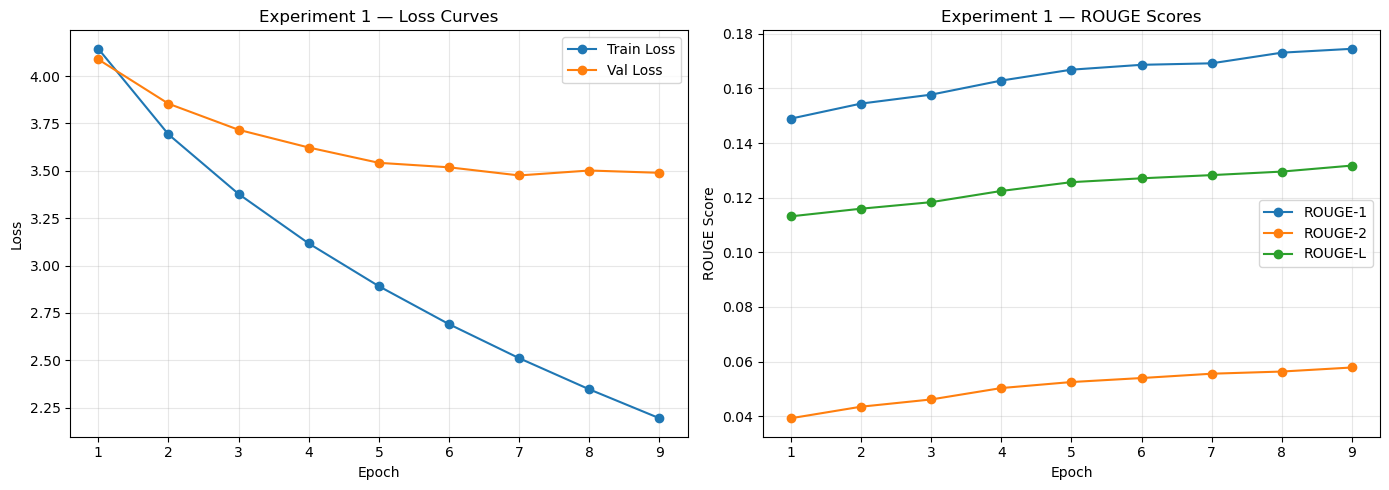

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history_df["epoch"], history_df["train_loss"], label="Train Loss", marker='o')
axes[0].plot(history_df["epoch"], history_df["val_loss"], label="Val Loss", marker='o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Experiment 1 — Loss Curves")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROUGE curves
axes[1].plot(history_df["epoch"], history_df["rouge1"], label="ROUGE-1", marker='o')
axes[1].plot(history_df["epoch"], history_df["rouge2"], label="ROUGE-2", marker='o')
axes[1].plot(history_df["epoch"], history_df["rougeL"], label="ROUGE-L", marker='o')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("ROUGE Score")
axes[1].set_title("Experiment 1 — ROUGE Scores")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Qualitative Examples  

Shows 5 model summaries vs human summaries.

In [13]:
qualitative_samples(
    df=val_df,
    model=model,
    encoder_tokenizer=bert_tokenizer,
    decoder_tokenizer=gpt_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",  # No prefix for BERT-GPT2
    seed=42,
)

--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Edd: wow, did you hear that they're transferring us to a different department? | Rose: whaaaaat :o | Rose: no! where'd you hear that? | Edd: well, it's quite official | Edd: Anderson just told us | Rose: and do you know what it changes for us? | Edd: they won't change the professors | Edd: but i know the paperwor ...
HUMAN: Rose and Edd will be transferred to a new department. Their professors will not change but paperwork will become more difficult.
MODEL: Eddie and Beatrice are going to give their university transfer to the professor. Beatrice is not sure if they need to change the university.    The university will change the paperwork. They will try to change their paperwork.  They will do the paperwork in the future, as Beatrice has already been given to the university, but it's not working for the university and they need more than the end of the current classes. They need to do it. They are not change the current students. 

In [18]:
# === Final ROUGE Summary ===
print("\nFinal ROUGE Scores (Best Epoch)")

# Find the best epoch (last one that improved)
if "improved" in history_df.columns:
    best_rows = history_df[history_df["improved"] == True]
    if len(best_rows) > 0:
        best_row = best_rows.iloc[-1]
    else:
        best_row = history_df.loc[history_df["val_loss"].idxmin()]
else:
    best_row = history_df.loc[history_df["val_loss"].idxmin()]

print(f"Best Epoch: {int(best_row['epoch'])}")
print(f"Validation Loss: {best_row['val_loss']:.4f}")
print()
print(f"ROUGE-1:    {best_row['rouge1']:.4f}")
print(f"ROUGE-2:    {best_row['rouge2']:.4f}")
print(f"ROUGE-L:    {best_row['rougeL']:.4f}")
print(f"ROUGE-Lsum: {best_row['rougeLsum']:.4f}")



Final ROUGE Scores (Best Epoch)
Best Epoch: 7
Validation Loss: 3.4757

ROUGE-1:    0.1692
ROUGE-2:    0.0556
ROUGE-L:    0.1283
ROUGE-Lsum: 0.1282


## 13. Save Model + Tokenizers

Matches your README exactly:

In [14]:
SAVE_DIR = PROJECT_ROOT / "models" / "bert-gpt2"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

model.save_pretrained(SAVE_DIR)
bert_tokenizer.save_pretrained(SAVE_DIR)
gpt_tokenizer.save_pretrained(SAVE_DIR)

print("Model saved to:", SAVE_DIR)

Model saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2


# Key Takeaways for Experiment-1

This section will be finished after training, but expected themes:

- Cross-attention warm-up stabilizes training  
- ROUGE improves slowly but plateaus early  
- Model tends to produce chatty, narrative summaries  
- Strong evidence this architecture is sub-optimal compared to BART/T5  

This notebook demonstrates the feasibility and limitations of a hand-assembled encoder–decoder system versus pretrained seq2seq models.